# Task 2: Results and Plots

This notebook collates the saved evaluation CSVs for Task 2 and produces quick plots/tables to compare models. It expects the repository layout to remain unchanged (CSV files and saved models under `Task 2/`).

In [8]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context="notebook", style="whitegrid", palette="colorblind")

root = Path(".")
aligned_path = root / "aligned_eval_summary.csv"
reward_samples_path = root / "reward_eval_samples.csv"
verbosity_bias_path = root / "verbosity_bias_eval.csv"
verbosity_len_path = root / "verbosity_length_eval.csv"

# Training logs
ppo_train_path = root / "ppo_aligned_model" / "ppo_training_logs.csv"
ppo_logs_path = root / "ppo_aligned_model" / "ppo_logs.csv"
dpo_train_path = root / "dpo_aligned_model" / "dpo_training_logs.csv"
grpo_train_path = root / "grpo_aligned_model" / "grpo_training_logs.csv"
rm_train_path = root / "reward_model" / "rm_training_logs.csv"

aligned_df = pd.read_csv(aligned_path)
reward_samples_df = pd.read_csv(reward_samples_path)
verbosity_bias_df = pd.read_csv(verbosity_bias_path)
verbosity_len_df = pd.read_csv(verbosity_len_path)

ppo_train_df = pd.read_csv(ppo_train_path)
ppo_logs_df = pd.read_csv(ppo_logs_path)
dpo_train_df = pd.read_csv(dpo_train_path)
grpo_train_df = pd.read_csv(grpo_train_path)
rm_train_df = pd.read_csv(rm_train_path)

print("Loaded eval CSVs:")
for name, df in [
    ("aligned_eval_summary", aligned_df),
    ("reward_eval_samples", reward_samples_df),
    ("verbosity_bias_eval", verbosity_bias_df),
    ("verbosity_length_eval", verbosity_len_df),
]:
    print(f"- {name}: {df.shape[0]} rows x {df.shape[1]} cols")

print("\nLoaded training logs:")
for name, df in [
    ("ppo_training_logs", ppo_train_df),
    ("ppo_logs (duplicate of training)", ppo_logs_df),
    ("dpo_training_logs", dpo_train_df),
    ("grpo_training_logs", grpo_train_df),
    ("rm_training_logs", rm_train_df),
]:
    print(f"- {name}: {df.shape[0]} rows x {df.shape[1]} cols")

print("\nSaved model directories:")
for p in sorted(root.glob("*_aligned_model")):
    print(f"- {p.name}")


Loaded eval CSVs:
- aligned_eval_summary: 14 rows x 3 cols
- reward_eval_samples: 20 rows x 10 cols
- verbosity_bias_eval: 3 rows x 7 cols
- verbosity_length_eval: 200 rows x 8 cols

Loaded training logs:
- ppo_training_logs: 100 rows x 3 cols
- ppo_logs (duplicate of training): 100 rows x 3 cols
- dpo_training_logs: 36 rows x 18 cols
- grpo_training_logs: 100 rows x 4 cols
- rm_training_logs: 38 rows x 10 cols

Saved model directories:
- dpo_aligned_model
- grpo_aligned_model
- ppo_aligned_model


## Aligned evaluation summary

Per-metric view for each method.

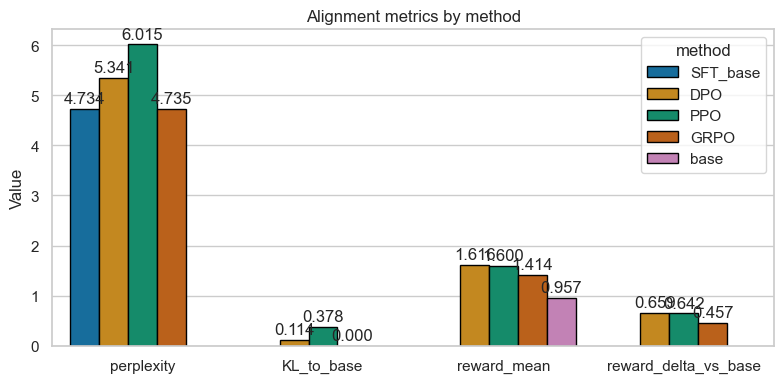

metric,KL_to_base,perplexity,reward_delta_vs_base,reward_mean
method,,,,
DPO,0.113784,5.340519,0.659019,1.616452
GRPO,0.000058,4.734829,0.456603,1.414035
PPO,0.378058,6.014901,0.642343,1.599775
SFT_base,NaN,4.733886,NaN,NaN
base,NaN,NaN,NaN,0.957432


In [9]:
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=aligned_df, x="metric", y="value", hue="method", edgecolor="black")
ax.set_title("Alignment metrics by method")
ax.set_ylabel("Value")
ax.set_xlabel("")
for c in ax.containers:
    ax.bar_label(c, fmt="{:.3f}", padding=2)
plt.tight_layout()
plt.show()

display(aligned_df.pivot(index="method", columns="metric", values="value"))

## Reward model scores

Distribution of reward scores per model on held-out samples, plus per-item inspection handles.

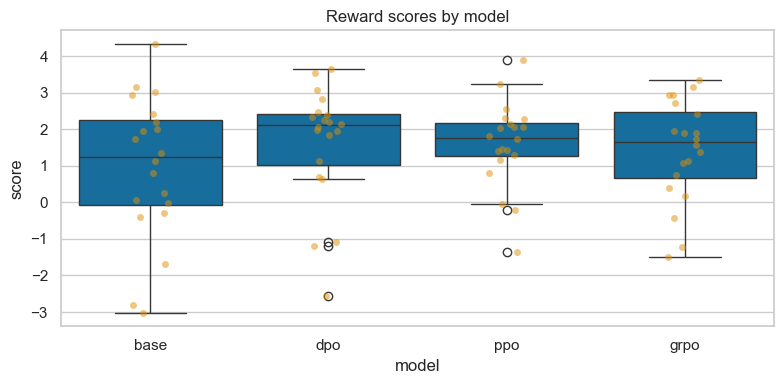

,mean,std,min,max
model,,,,
dpo,1.616452,1.615454,-2.566818,3.656777
ppo,1.599775,1.183172,-1.362490,3.907988
grpo,1.414036,1.396543,-1.501443,3.350509
base,0.957432,1.970063,-3.021008,4.338137



Top 2 for base_score:


,idx,prompt,base_score
9,9,System: You are an AI assistant. User will you...,4.338137
13,13,System: You are an AI assistant. You will be g...,3.165046


Bottom 2 for base_score:


,idx,prompt,base_score
6,6,System: You are an AI assistant. You will be g...,-3.021008
3,3,"System: You are a helpful assistant, who alway...",-2.816965



Top 2 for dpo_score:


,idx,prompt,dpo_score
9,9,System: You are an AI assistant. User will you...,3.656777
13,13,System: You are an AI assistant. You will be g...,3.541467


Bottom 2 for dpo_score:


,idx,prompt,dpo_score
14,14,System: You are an AI assistant. You will be g...,-2.566818
12,12,System: You are an AI assistant. User will you...,-1.191668



Top 2 for ppo_score:


,idx,prompt,ppo_score
13,13,System: You are an AI assistant. You will be g...,3.907988
5,5,"System: You are a teacher. Given a task, you e...",3.231489


Bottom 2 for ppo_score:


,idx,prompt,ppo_score
17,17,"System: You are a helpful assistant, who alway...",-1.362490
14,14,System: You are an AI assistant. You will be g...,-0.217506



Top 2 for grpo_score:


,idx,prompt,grpo_score
13,13,System: You are an AI assistant. You will be g...,3.350509
10,10,System: You are an AI assistant. You will be g...,3.148127


Bottom 2 for grpo_score:


,idx,prompt,grpo_score
14,14,System: You are an AI assistant. You will be g...,-1.501443
7,7,System: You are an AI assistant. User will you...,-1.216789


In [10]:
score_cols = ["base_score", "dpo_score", "ppo_score", "grpo_score"]
score_long = reward_samples_df.melt(
    id_vars=["idx"], value_vars=score_cols, var_name="model", value_name="score"
)
score_long["model"] = score_long["model"].str.replace("_score", "", regex=False)

plt.figure(figsize=(8, 4))
ax = sns.boxplot(data=score_long, x="model", y="score")
sns.stripplot(data=score_long, x="model", y="score", dodge=True, alpha=0.5, ax=ax)
ax.set_title("Reward scores by model")
plt.tight_layout()
plt.show()

mean_scores = score_long.groupby("model")["score"].agg(["mean", "std", "min", "max"]).sort_values("mean", ascending=False)
display(mean_scores)

# Inspect the highest/lowest scoring prompts per model if needed
def topk(df, col, k=3, largest=True):
    return df.nlargest(k, col) if largest else df.nsmallest(k, col)

for col in score_cols:
    print(f"\nTop 2 for {col}:")
    display(topk(reward_samples_df, col, k=2)[["idx", "prompt", col]])
    print(f"Bottom 2 for {col}:")
    display(topk(reward_samples_df, col, k=2, largest=False)[["idx", "prompt", col]])

## Verbosity bias evaluation

Shows the reward model preference gap between concise and verbose-but-wrong answers.

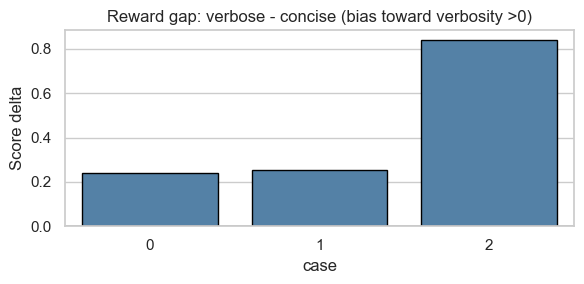

,case,rm_concise,rm_verbose_wrong,delta_verbose_minus_concise
0,0,1.880059,2.120713,0.240654
1,1,3.019720,3.272767,0.253047
2,2,2.631071,3.472290,0.841218


In [11]:
plt.figure(figsize=(6, 3))
ax = sns.barplot(
    data=verbosity_bias_df,
    x="case",
    y="delta_verbose_minus_concise",
    color="steelblue",
    edgecolor="black",
)
ax.axhline(0, color="black", linewidth=1)
ax.set_title("Reward gap: verbose - concise (bias toward verbosity >0)")
ax.set_ylabel("Score delta")
plt.tight_layout()
plt.show()

display(verbosity_bias_df[["case", "rm_concise", "rm_verbose_wrong", "delta_verbose_minus_concise"]])

## Verbosity length evaluation

Length compliance and over-limit stats per model.

/var/folders/80/08nsjy_s5f3brjxw1crm6mbh0000gn/T/ipykernel_78662/1645135419.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  verbosity_len_df.assign(compliant_flag=verbosity_len_df["compliant"].fillna(False))


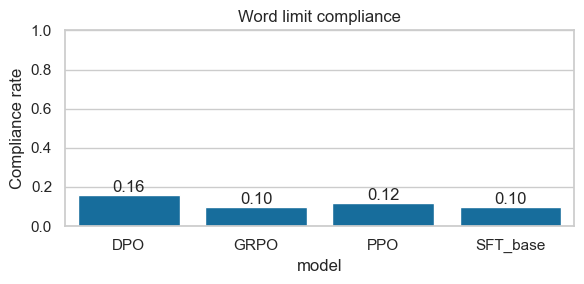

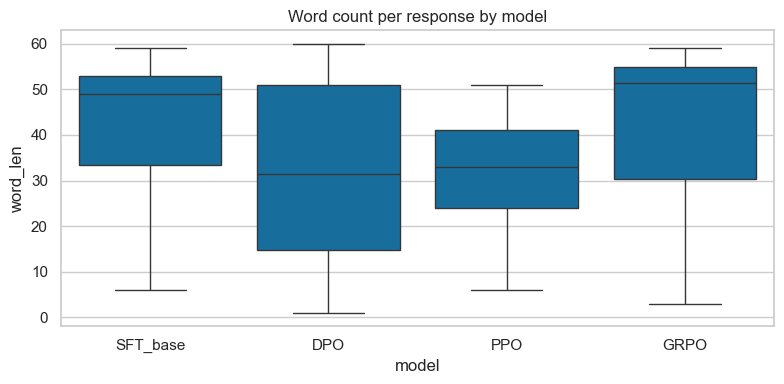

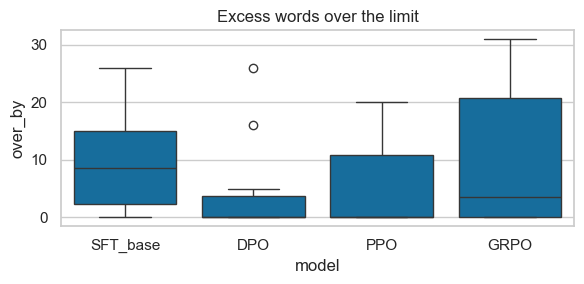

In [12]:
# Compliance rate per model
compliance = (
    verbosity_len_df.assign(compliant_flag=verbosity_len_df["compliant"].fillna(False))
    .groupby("model")["compliant_flag"]
    .mean()
    .reset_index()
)
plt.figure(figsize=(6, 3))
ax = sns.barplot(data=compliance, x="model", y="compliant_flag")
ax.set_ylim(0, 1)
ax.set_ylabel("Compliance rate")
ax.set_title("Word limit compliance")
for c in ax.containers:
    ax.bar_label(c, fmt="{:.2f}")
plt.tight_layout()
plt.show()

# Word length distribution by model
plt.figure(figsize=(8, 4))
sns.boxplot(data=verbosity_len_df, x="model", y="word_len")
plt.title("Word count per response by model")
plt.tight_layout()
plt.show()

# Over-limit analysis (only rows that exceeded limit)
over_df = verbosity_len_df.dropna(subset=["over_by"])
if not over_df.empty:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=over_df, x="model", y="over_by")
    plt.title("Excess words over the limit")
    plt.tight_layout()
    plt.show()
else:
    print("No over-limit cases in this evaluation set.")

## Training curves (loss, reward, KL)

Curves pulled from the saved training logs to show optimization behavior for PPO/GRPO/DPO and the reward model.

### PPO training (mean reward and KL)

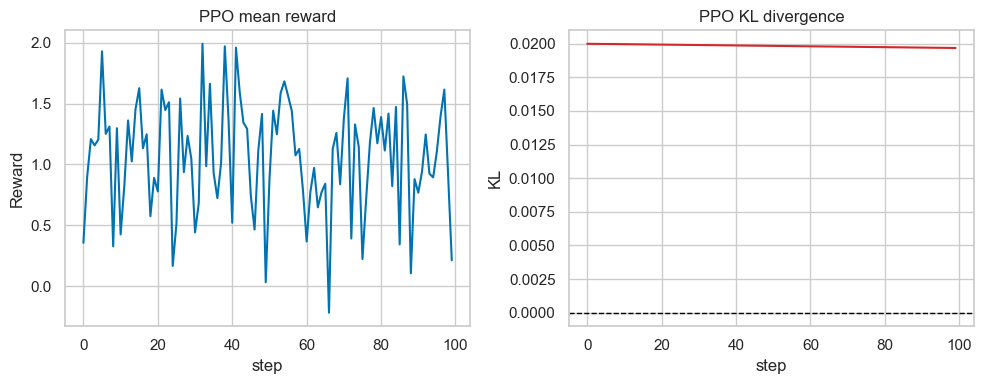

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=ppo_train_df, x="step", y="mean_reward", ax=axes[0])
axes[0].set_title("PPO mean reward")
axes[0].set_ylabel("Reward")
sns.lineplot(data=ppo_train_df, x="step", y="kl", ax=axes[1], color="tab:red")
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")
axes[1].set_title("PPO KL divergence")
axes[1].set_ylabel("KL")
plt.tight_layout()
plt.show()


### GRPO training (loss, reward, KL)

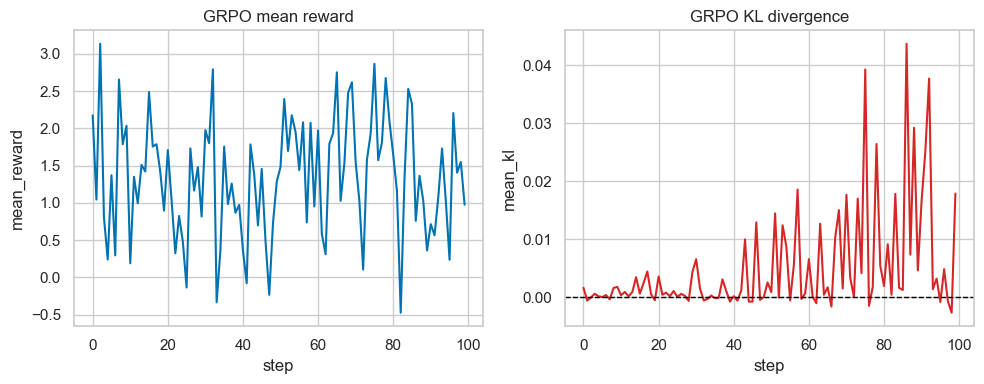

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.lineplot(data=grpo_train_df, x="step", y="mean_reward", ax=axes[0])
axes[0].set_title("GRPO mean reward")
sns.lineplot(data=grpo_train_df, x="step", y="mean_kl", ax=axes[1], color="tab:red")
axes[1].axhline(0, color="black", linewidth=1, linestyle="--")
axes[1].set_title("GRPO KL divergence")
for ax in axes: ax.set_xlabel("step")
plt.tight_layout()
plt.show()


### DPO training (loss and reward stats)

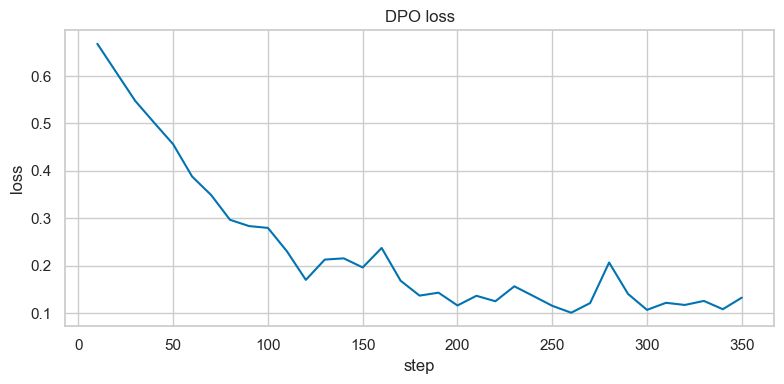

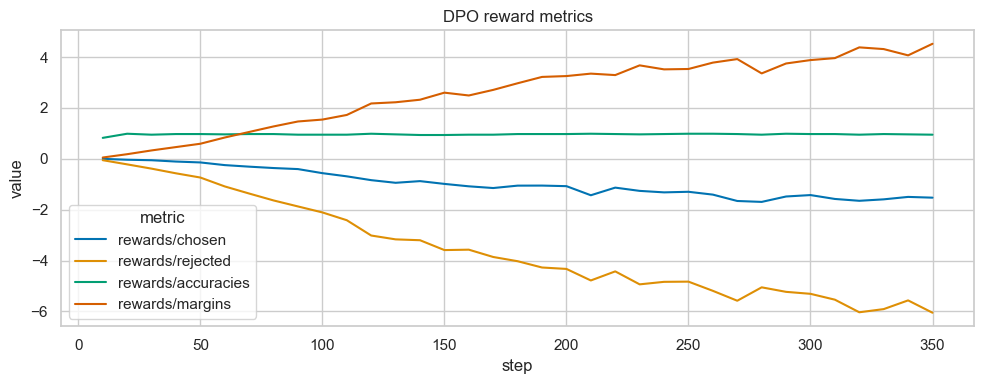

In [15]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=dpo_train_df, x="step", y="loss")
plt.title("DPO loss")
plt.tight_layout()
plt.show()

# Reward-related columns (drop columns that are entirely NaN)
reward_cols = [c for c in dpo_train_df.columns if c.startswith("rewards/")]
reward_cols = [c for c in reward_cols if not dpo_train_df[c].isna().all()]
if reward_cols:
    melt_df = dpo_train_df.melt(id_vars="step", value_vars=reward_cols, var_name="metric", value_name="value")
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=melt_df, x="step", y="value", hue="metric")
    plt.title("DPO reward metrics")
    plt.tight_layout()
    plt.show()
else:
    print("No non-NaN reward columns found in DPO logs.")


### Reward model training (loss)

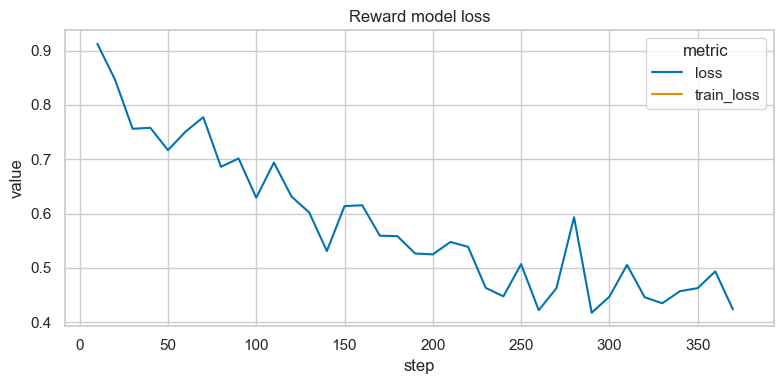

In [16]:
loss_cols = [c for c in ["loss", "train_loss"] if c in rm_train_df.columns]
plot_df = rm_train_df.melt(id_vars="step", value_vars=loss_cols, var_name="metric", value_name="value")
plt.figure(figsize=(8, 4))
sns.lineplot(data=plot_df, x="step", y="value", hue="metric")
plt.title("Reward model loss")
plt.tight_layout()
plt.show()
